In [1]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import HashingTF, Tokenizer
from pyspark.sql import Row
from pyspark.sql.functions import udf, desc, col
from pyspark.sql.types import *
from pyspark.sql import SparkSession

In [2]:
# Spark session & context
spark = SparkSession.builder.master('local').getOrCreate()
sc = spark.sparkContext

In [3]:
df1 = spark.read.option("delimiter", ",").option("header", True).csv("food.csv")
df1.show()

+-------------+--------------------+--------------------+---------+-------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+
|Inspection ID|            DBA Name|            AKA Name|License #|Facility Type|           Risk|             Address|   City|State|  Zip|Inspection Date|     Inspection Type|           Results|          Violations|          Latitude|         Longitude|            Location|
+-------------+--------------------+--------------------+---------+-------------+---------------+--------------------+-------+-----+-----+---------------+--------------------+------------------+--------------------+------------------+------------------+--------------------+
|      2591128|             VIAGGIO|             VIAGGIO|  2891446|   Restaurant|  Risk 1 (High)|  1027 W MADISON ST |CHICAGO|   IL|60607|     03/15/2024|      Non-Inspection|

In [4]:
df1.printSchema()

root
 |-- Inspection ID: string (nullable = true)
 |-- DBA Name: string (nullable = true)
 |-- AKA Name: string (nullable = true)
 |-- License #: string (nullable = true)
 |-- Facility Type: string (nullable = true)
 |-- Risk: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- State: string (nullable = true)
 |-- Zip: string (nullable = true)
 |-- Inspection Date: string (nullable = true)
 |-- Inspection Type: string (nullable = true)
 |-- Results: string (nullable = true)
 |-- Violations: string (nullable = true)
 |-- Latitude: string (nullable = true)
 |-- Longitude: string (nullable = true)
 |-- Location: string (nullable = true)



In [5]:
inspections = df1.select("Inspection ID", "DBA Name", "Results", "Violations")
inspections.show()

+-------------+--------------------+------------------+--------------------+
|Inspection ID|            DBA Name|           Results|          Violations|
+-------------+--------------------+------------------+--------------------+
|      2591128|             VIAGGIO|          No Entry|                NULL|
|      2591055| SEASHELL RESTAURANT|          No Entry|                NULL|
|      2591047|LILCOUNTRY SOUL FOOD|              Pass|51. PLUMBING INST...|
|      2591107|     LOW REZ BREWING|   Out of Business|                NULL|
|      2591035|MONOCHROME BREWIN...|Pass w/ Conditions|                NULL|
|      2591000|      FLIP N D'S INC|              Pass|                NULL|
|      2590929|RESURRECTION HIGH...|              Fail|2. CITY OF CHICAG...|
|      2590938|      Cuates Grocery|         Not Ready|                NULL|
|      2590917|              SUBWAY|              Pass|51. PLUMBING INST...|
|      2590911|                CAVA|              Pass|                NULL|

In [6]:
inspections = inspections.dropna()
inspections.show()

+-------------+--------------------+-------+--------------------+
|Inspection ID|            DBA Name|Results|          Violations|
+-------------+--------------------+-------+--------------------+
|      2591047|LILCOUNTRY SOUL FOOD|   Pass|51. PLUMBING INST...|
|      2590929|RESURRECTION HIGH...|   Fail|2. CITY OF CHICAG...|
|      2590917|              SUBWAY|   Pass|51. PLUMBING INST...|
|      2590875|Standard Bar & Grill|   Pass|10. ADEQUATE HAND...|
|      2590820|     Sze Chuan Alley|   Pass|16. FOOD-CONTACT ...|
|      2590802|          SOFT BITES|   Fail|10. ADEQUATE HAND...|
|      2590748|   CMM FOOD SERVICES|   Fail|16. FOOD-CONTACT ...|
|      2590743|Dewitt Clinton El...|   Pass|47. FOOD & NON-FO...|
|      2590722|            FISH BAR|   Fail|16. FOOD-CONTACT ...|
|      2590711|            MOMOTARO|   Pass|10. ADEQUATE HAND...|
|      2590665|   EPPLES RESTAURANT|   Pass|47. FOOD & NON-FO...|
|      2590651|                  BP|   Pass|10. ADEQUATE HAND...|
|      259

In [7]:
nbre = inspections.groupby("Results").count().withColumnRenamed("count", "nb").orderBy(col("nb").desc())
nbre.printSchema()

root
 |-- Results: string (nullable = true)
 |-- nb: long (nullable = false)



In [8]:
nbre.take(4)

[Row(Results='Pass', nb=105212),
 Row(Results='Fail', nb=49172),
 Row(Results='Pass w/ Conditions', nb=40204),
 Row(Results='No Entry', nb=658)]

In [9]:
nbre.show(4)

+------------------+------+
|           Results|    nb|
+------------------+------+
|              Pass|105212|
|              Fail| 49172|
|Pass w/ Conditions| 40204|
|          No Entry|   658|
+------------------+------+
only showing top 4 rows



In [10]:
nbre.explain(True)

== Parsed Logical Plan ==
'Sort ['nb DESC NULLS LAST], true
+- Project [Results#29, count#193L AS nb#196L]
   +- Aggregate [Results#29], [Results#29, count(1) AS count#193L]
      +- Filter atleastnnonnulls(4, Inspection ID#17, DBA Name#18, Results#29, Violations#30)
         +- Project [Inspection ID#17, DBA Name#18, Results#29, Violations#30]
            +- Relation [Inspection ID#17,DBA Name#18,AKA Name#19,License ##20,Facility Type#21,Risk#22,Address#23,City#24,State#25,Zip#26,Inspection Date#27,Inspection Type#28,Results#29,Violations#30,Latitude#31,Longitude#32,Location#33] csv

== Analyzed Logical Plan ==
Results: string, nb: bigint
Sort [nb#196L DESC NULLS LAST], true
+- Project [Results#29, count#193L AS nb#196L]
   +- Aggregate [Results#29], [Results#29, count(1) AS count#193L]
      +- Filter atleastnnonnulls(4, Inspection ID#17, DBA Name#18, Results#29, Violations#30)
         +- Project [Inspection ID#17, DBA Name#18, Results#29, Violations#30]
            +- Relation [Ins

In [11]:
nbre.describe()

DataFrame[summary: string, Results: string, nb: string]

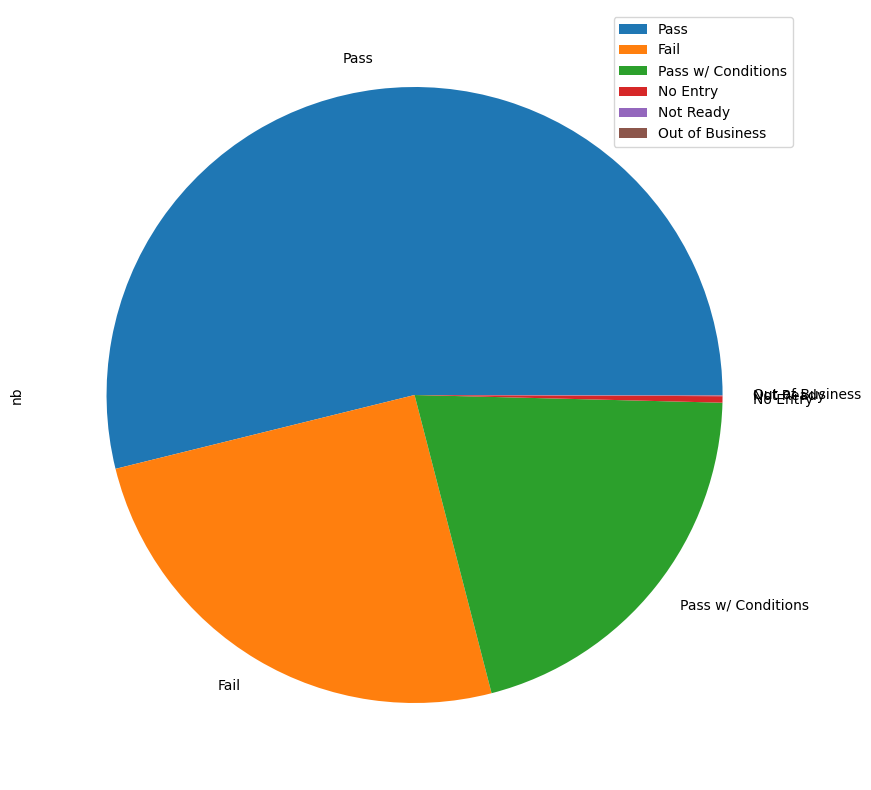

In [12]:
plot_pd = nbre.toPandas()
plot_pd.set_index("Results", inplace=True)
plt = plot_pd.plot.pie(y="nb", figsize=(10,10))
plt.figure.savefig('pie.pdf')

# Predictions with spark

### Labelling data: defining categories

In [13]:
def labelForResults(s):
    if s == 'Fail':
        return 0.0
    elif s == 'Pass w/ Conditions' or s == 'Pass':
        return 1.0
    else:
        return -1.0

In [14]:
udf_logistic = udf(labelForResults, DoubleType())
labeledData = inspections.select(udf_logistic("Results"), "Violations").withColumnRenamed("labelForResults(Results)", "label").withColumnRenamed("Violations", "violations")
labeledData = labeledData.filter(labeledData["label"] >= 0)
labeledData.count()

194588

In [15]:
trainingDf, validationDf = labeledData.randomSplit([0.75, 0.25], 105)
trainingDf.count()

145799

In [16]:
validationDf.count()

48789

# Defining the model: specifying predictive variables and tuning parameters

In [17]:
tokenizer = Tokenizer(inputCol="violations", outputCol="words")
hashingTF = HashingTF(inputCol=tokenizer.getOutputCol(), outputCol="features")
lr = LogisticRegression(maxIter=10, regParam=0.01)
pipeline = Pipeline(stages=[tokenizer, hashingTF, lr])

In [18]:
model = pipeline.fit(trainingDf)

In [19]:
prediction = model.transform(validationDf)

In [20]:
selected = prediction.select("violations", "probability", "prediction")
counter = 0
for row in selected.collect():
    if counter == 20:
        break
    violation, prob, prediction = row
    print(f"{violation} {str(prob)} {prediction}")
    counter+=1

1. PERSON IN CHARGE PRESENT, DEMONSTRATES KNOWLEDGE, AND PERFORMS DUTIES - Comments:  2-101.11 PERSON IN CHARGE DOES NOT POSSESS A CITY OF CHICAGO SANITATION CERTIFICATE. INSTRUCTED ALL PERSONS IN CHARGE MUST HAVE A CITY SANITATION CERTIFICATE. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED. | 25. CONSUMER ADVISORY PROVIDED FOR RAW/UNDERCOOKED FOOD - Comments:  3-603.11 MENU DOES NOT DISCLOSE AND INFORM CONSUMERS THE SPECIFIC MENU ITEMS THAT ARE RAW OR UNDER COOKED AND A POTENTIAL HAZARD OF CONSUMING SUCH FOOD. MUST PROVIDE A CONSUMER ADVISORY AND DISCLOSE SUCH ITEMS. PRIORITY FOUNDATION VIOLATION. NO CITATION ISSUED. | 37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments:  3-602.11(A; B:1-4,6,7; C; D) ALL PREPACKAGED PREPARED FOODS IN THE FRONT DISPLAY COOLER SUCH AS: PASTA SALAD, SANDWICHES, GREEN SALADS MUST BE PROPERLY LABELED WITH BUSINESS NAME, ADDRESS AND LIST OF INGREDIENTS. | 37. FOOD PROPERLY LABELED; ORIGINAL CONTAINER - Comments:  3-602.11(B:5) ALL PREPACKAGED GRANOL